In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
from ln_utils import *

In [3]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

# Parameters

In [4]:
from datawand.parametrization import ParamHelper
ph = ParamHelper("../", "LNGraph", sys.argv)

['/home/fberes/anaconda3/envs/dm-3-env/lib/python3.5/site-packages/ipykernel/__main__.py', '-f', '/run/user/51880/jupyter/kernel-15fb6fce-0153-45e6-838d-84fa0b3db8cb.json']
/home/fberes/git/LNDynamicTopology
/home/fberes/git/LNDynamicTopology
Default parameters:
{'max_time': 1553947199, 'time_window': 604800, 'min_time': 1548979201, 'weight': None, 'data_dir': '/mnt/idms/fberes/data/bitcoin_ln_research'}
Custom parameters:
{}


In [5]:
data_dir = ph.get("data_dir")
stat_dir = "%s/centrality_scores/" % data_dir
print(stat_dir)

Using default parameter: data_dir=/mnt/idms/fberes/data/bitcoin_ln_research
/mnt/idms/fberes/data/bitcoin_ln_research/centrality_scores/


In [6]:
time_window = ph.get("time_window")
MIN_TIME = ph.get("min_time")
MAX_TIME = ph.get("max_time")

Using default parameter: time_window=604800
Using default parameter: min_time=1548979201
Using default parameter: max_time=1553947199


# Load data

## a.) Graph data

In [7]:
edges = pd.read_csv("%s/directed_temporal_edges.csv" % data_dir)

In [8]:
edges = edges[(edges["last_update"] >= MIN_TIME) & (edges["last_update"] <= MAX_TIME)]

In [9]:
edges = edges.sort_values("last_update")

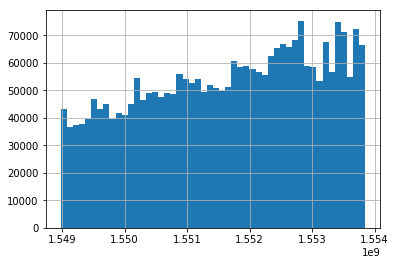

In [10]:
edges["last_update"].hist(bins=50)

## b.) Precomputed centrality scores

In [11]:
snapshot_ids = range(8)#range(9)

In [12]:
weight_cols = [None, "capacity", "fee_base_msat", "fee_rate_milli_msat"]

In [13]:
centrality_scores = load_centrality_scores(stat_dir, snapshot_ids, weight_cols, drop_cols=["deg"])

In [14]:
def calculate_ranks(scores, snapshot_ids, weight_cols):
    ranks = {}
    for w in weight_cols:
        ranks[w] = []
        for i in snapshot_ids:
            ranks[w].append(scores[w][i].set_index("index").rank(ascending=False).reset_index().rename({"index":"node_pub"},axis=1))
    return ranks

In [15]:
centrality_ranks = calculate_ranks(centrality_scores, snapshot_ids, weight_cols)

# Calculate centrality ranks of popular nodes

   * **popular nodes** are those (already seen nodes) that new nodes connect to most frequently

In [16]:
edges.head()

,src,trg,last_update,channel_id,capacity,disabled,fee_base_msat,fee_rate_milli_msat,min_htlc
24776,027ce055380348d7812d2ae7745701c9f93e70c1adeb26...,02b2bf1b75301372ed16ea7658af0d49152e37760c8951...,1548979201,616479677165207552,91307,False,1000.0,1.0,1000.0
24777,02b2bf1b75301372ed16ea7658af0d49152e37760c8951...,027ce055380348d7812d2ae7745701c9f93e70c1adeb26...,1548979201,616479677165207552,91307,False,1000.0,1.0,1000.0
24778,02baf5476270b437cb04ff2683b0866bbeb8f24353377b...,0331f80652fb840239df8dc99205792bba2e559a054699...,1548979206,615186651423375360,2000000,False,1000.0,1.0,1.0
24779,0331f80652fb840239df8dc99205792bba2e559a054699...,02baf5476270b437cb04ff2683b0866bbeb8f24353377b...,1548979206,615186651423375360,2000000,False,1000.0,100.0,1000.0
24780,0331f80652fb840239df8dc99205792bba2e559a054699...,03fd5d4b4eb03c531749a1abf197d8f09e48b54e2540fa...,1548979209,615515405345554432,500000,False,1000.0,1.0,1000.0


In [17]:
snapshot_graphs, snapshot_edges = get_snapshots(edges, MIN_TIME, MAX_TIME, time_window, weight_cols[1:])

1 41766
2 52824
3 60328
4 67834
5 75238
6 85818
7 96222
8 100144
9 100464


### last snapshot is much smaller!!!

In [18]:
for snap in snapshot_edges:
    print(len(snap))

252666
275466
304550
322520
339484
383326
396164
405920
19090


In [19]:
snapshot_graphs = snapshot_graphs[:-1]
snapshot_edges = snapshot_edges[:-1]

In [20]:
attachments = observe_node_attachements_over_time(snapshot_ids, snapshot_graphs, snapshot_edges, centrality_ranks, weight_cols)

2719
(4388, 29)
3038
(3836, 29)
3288
(5765, 29)
3642
(3496, 29)
3912
(5331, 29)
4170
(12816, 29)
4380
(2462, 29)


# Analyse ranks of popular nodes

In [21]:
attachments[0].head()

,new_node,old_node,last_update,channel_id,capacity,disabled,fee_base_msat,fee_rate_milli_msat,min_htlc,node_pub,...,node_pub_fee_base_msat,betw_fee_base_msat,in_deg_fee_base_msat,out_deg_fee_base_msat,pr_fee_base_msat,node_pub_fee_rate_milli_msat,betw_fee_rate_milli_msat,in_deg_fee_rate_milli_msat,out_deg_fee_rate_milli_msat,pr_fee_rate_milli_msat
0,0348d6d772daebb2f2c13294f1ba5dbf21514e3766a24e...,03864ef025fde8fb587d989186ce6a4a186895ee44a926...,1549592446,618001401158041601,599651,True,1000.0,100.0,1000.0,03864ef025fde8fb587d989186ce6a4a186895ee44a926...,...,03864ef025fde8fb587d989186ce6a4a186895ee44a926...,70.0,6.0,18.0,5.0,03864ef025fde8fb587d989186ce6a4a186895ee44a926...,9.0,35.0,32.0,11.0
1,029fa6ec07e53ecc93de589b3952888cbbcecea5fb15bb...,0331f80652fb840239df8dc99205792bba2e559a054699...,1549598169,618015694779580417,30000,False,1000.0,1.0,1000.0,0331f80652fb840239df8dc99205792bba2e559a054699...,...,0331f80652fb840239df8dc99205792bba2e559a054699...,65.0,7.5,21.0,2.0,0331f80652fb840239df8dc99205792bba2e559a054699...,2.0,144.5,1.0,26.0
2,032ccdb7690173137e692db603c20a6ba3230b8ec82e67...,0331f80652fb840239df8dc99205792bba2e559a054699...,1549599750,618017893938954241,1000000,False,1000.0,1.0,1000.0,0331f80652fb840239df8dc99205792bba2e559a054699...,...,0331f80652fb840239df8dc99205792bba2e559a054699...,65.0,7.5,21.0,2.0,0331f80652fb840239df8dc99205792bba2e559a054699...,2.0,144.5,1.0,26.0
3,02d8eba7ff95342d40497e83fafeb49c0af4b50c03e68e...,039bcf7778ad7b14cf5974cd2705b06a58a8bbf564ca1d...,1549600088,580287052882182144,444445,True,1000.0,1.0,1000.0,039bcf7778ad7b14cf5974cd2705b06a58a8bbf564ca1d...,...,039bcf7778ad7b14cf5974cd2705b06a58a8bbf564ca1d...,78.0,53.5,103.0,31.0,039bcf7778ad7b14cf5974cd2705b06a58a8bbf564ca1d...,16.0,364.5,131.0,63.0
4,0207197d1028b8a7edfee28f4e2dc47905333b2c4f9ed4...,039bcf7778ad7b14cf5974cd2705b06a58a8bbf564ca1d...,1549600088,580395904482082816,444445,True,1000.0,1.0,1000.0,039bcf7778ad7b14cf5974cd2705b06a58a8bbf564ca1d...,...,039bcf7778ad7b14cf5974cd2705b06a58a8bbf564ca1d...,78.0,53.5,103.0,31.0,039bcf7778ad7b14cf5974cd2705b06a58a8bbf564ca1d...,16.0,364.5,131.0,63.0


## a.) New attachments per weeks

   * there is a huge peek on week 5!!!

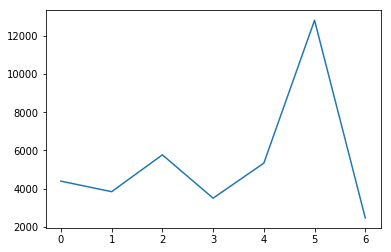

In [22]:
x = range(len(attachments))
y = [len(att) for att in attachments]
plt.plot(x,y)

## b.) Weekly correlations of popular nodes

In [23]:
pop_df = get_attachement_popularity(attachments)

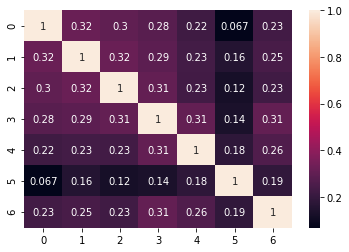

In [24]:
sns.heatmap(corr_mx(pop_df, "spearman"), annot=True)

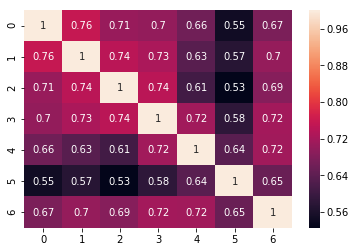

In [25]:
sns.heatmap(corr_mx(pop_df, "wkendall"), annot=True)

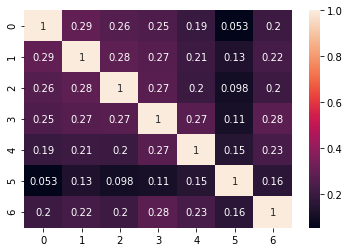

In [26]:
sns.heatmap(corr_mx(pop_df, "kendall"), annot=True)

## c.) Weekly correlations of popular and most central nodes

In [27]:
sp = pop_corr_with_centralities(pop_df, centrality_scores, weight_cols, method="spearman")
ke = pop_corr_with_centralities(pop_df, centrality_scores, weight_cols, method="kendall")
wk = pop_corr_with_centralities(pop_df, centrality_scores, weight_cols, method="wkendall")

### i.) mean correlation for the observed weeks

#### Observations

   - popular nodes correlates the most with capacity weighted betweeness nodes (and high degree nodes)
   - our suggestion would be to connect to 'betw_fee_base_msat', 'betw_fee_rate_milli_msat' nodes - **but later these nodes could raise the fees?**
   - **'betw_fee_base_msat' is in top2 for kendall!!!** - interesting

In [28]:
sp.mean(axis=0).sort_values(ascending=False)

out_deg                        0.419539
in_deg                         0.419539
betw_capacity                  0.417840
pr                             0.416778
betw                           0.404161
pr_capacity                    0.397901
out_deg_capacity               0.395762
in_deg_capacity                0.395665
betw_fee_base_msat             0.388928
out_deg_fee_base_msat          0.384585
in_deg_fee_base_msat           0.376236
pr_fee_base_msat               0.366755
betw_fee_rate_milli_msat       0.355823
out_deg_fee_rate_milli_msat    0.354701
pr_fee_rate_milli_msat         0.335977
in_deg_fee_rate_milli_msat     0.323325
dtype: float64

In [29]:
wk.mean(axis=0).sort_values(ascending=False)

betw_capacity                  0.777603
out_deg                        0.772253
in_deg                         0.772253
pr                             0.768312
betw                           0.764579
pr_capacity                    0.751884
in_deg_capacity                0.743044
out_deg_capacity               0.743019
betw_fee_base_msat             0.737645
betw_fee_rate_milli_msat       0.722225
out_deg_fee_rate_milli_msat    0.699312
pr_fee_base_msat               0.676287
in_deg_fee_base_msat           0.661546
pr_fee_rate_milli_msat         0.652507
out_deg_fee_base_msat          0.570751
in_deg_fee_rate_milli_msat     0.552310
dtype: float64

In [30]:
ke.mean(axis=0).sort_values(ascending=False)

betw_capacity                  0.388635
betw_fee_base_msat             0.360802
out_deg                        0.348534
in_deg                         0.348534
pr                             0.335498
betw                           0.334099
pr_capacity                    0.319415
out_deg_capacity               0.317711
in_deg_capacity                0.317629
out_deg_fee_base_msat          0.314897
in_deg_fee_base_msat           0.310918
betw_fee_rate_milli_msat       0.297860
pr_fee_base_msat               0.294225
out_deg_fee_rate_milli_msat    0.286627
pr_fee_rate_milli_msat         0.268959
in_deg_fee_rate_milli_msat     0.263272
dtype: float64

### ii.) weekly correlation timeseries

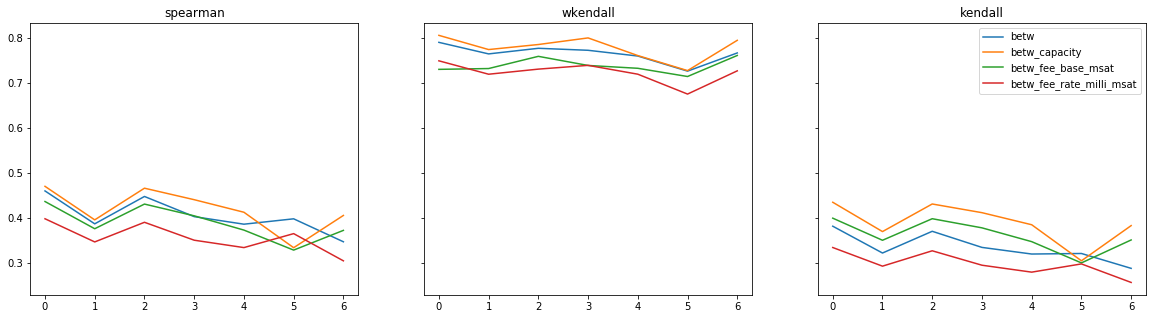

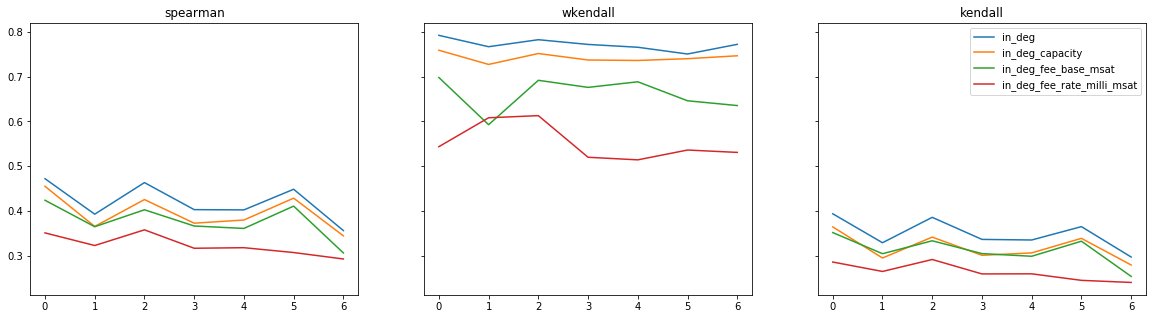

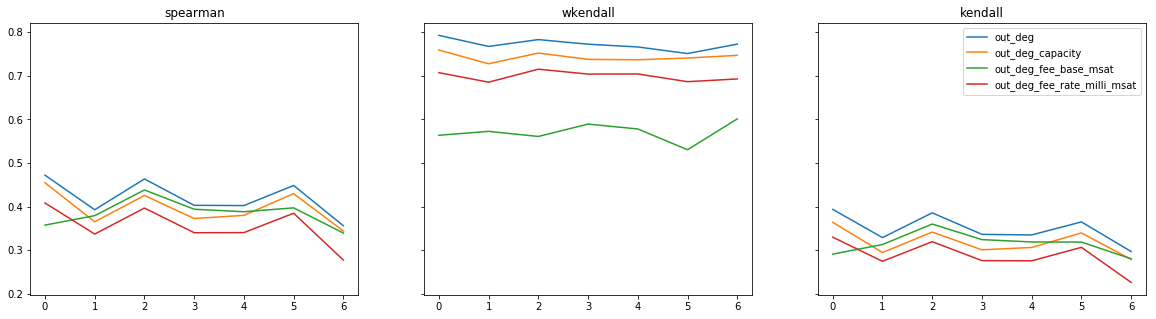

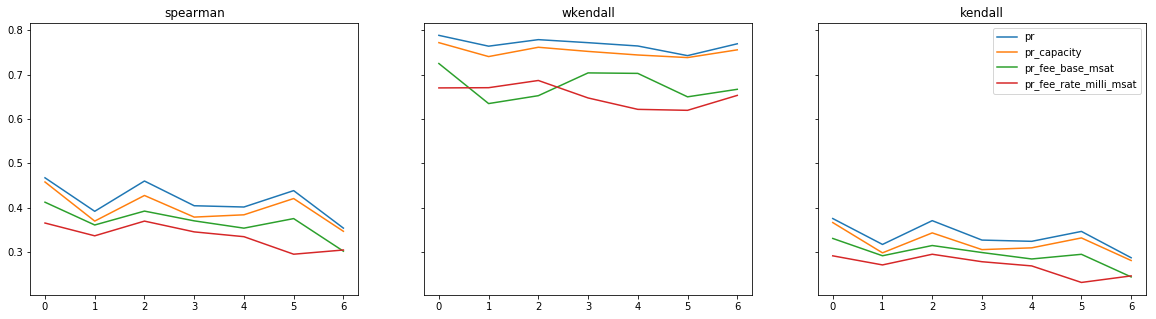

In [31]:
for c in ["betw","in_deg","out_deg","pr"]:
    plot_corr_time_series_with_pop(sp, ke, wk, [c+postfix for postfix in ["","_capacity","_fee_base_msat", "_fee_rate_milli_msat"]])

### Most popular nodes:

In [32]:
pop_df.head()

,0,1,2,3,4,5,6
0331f80652fb840239df8dc99205792bba2e559a05469915804c08420230e23c7c,245.0,169.0,236.0,154.0,165.0,113.0,86.0
03864ef025fde8fb587d989186ce6a4a186895ee44a926bfc370e2c366597a3f8f,138.0,127.0,146.0,136.0,67.0,98.0,101.0
0217890e3aad8d35bc054f43acc00084b25229ecff0ab68debd82883ad65ee8266,138.0,112.0,165.0,104.0,129.0,112.0,91.0
039bcf7778ad7b14cf5974cd2705b06a58a8bbf564ca1df4791100f81104716624,102.0,7.0,0.0,0.0,0.0,0.0,0.0
02ad6fb8d693dc1e4569bcedefadf5f72a931ae027dc0f0c544b34c1c6f3b9a02b,93.0,37.0,83.0,16.0,42.0,68.0,35.0


In [33]:
most_pop = pop_df.rank(ascending=False).mean(axis=1).sort_values()[:50]

In [34]:
most_pop.head(10)

0331f80652fb840239df8dc99205792bba2e559a05469915804c08420230e23c7c     3.642857
0217890e3aad8d35bc054f43acc00084b25229ecff0ab68debd82883ad65ee8266     5.071429
03864ef025fde8fb587d989186ce6a4a186895ee44a926bfc370e2c366597a3f8f     8.142857
03bb88ccc444534da7b5b64b4f7b15e1eccb18e102db0e400d4b9cfe93763aa26d    16.142857
03c2abfa93eacec04721c019644584424aab2ba4dff3ac9bdab4e9c97007491dda    16.642857
0232e20e7b68b9b673fb25f48322b151a93186bffe4550045040673797ceca43cf    17.642857
02ad6fb8d693dc1e4569bcedefadf5f72a931ae027dc0f0c544b34c1c6f3b9a02b    18.857143
0390b5d4492dc2f5318e5233ab2cebf6d48914881a33ef6a9c6bcdbb433ad986d0    18.928571
03c436af41160a355fc1ed230a64f6a64bcbd2ae50f12171d1318f9782602be601    21.071429
0279c22ed7a068d10dc1a38ae66d2d6461e269226c60258c021b1ddcdfe4b00bc4    22.071429
dtype: float64

In [35]:
def get_cent_rank(node, cent, weight, idx):
    rank = -1
    try:
        rank = centrality_ranks[weight][idx].set_index("node_pub").loc[node][cent]
    finally:
        return rank 

### Betweeness ranks of most popular nodes on weeks 1-5-8:

#### Huge gain in betweeness: 

- 27 - 8 - 8 (5th)
- 157 - 6 - 9 (11th)
- 25 - 16 - 14 (16th)
- 51 - 30 - 22 (21th)

etc.

#### Ideas:

   - node2vec-el klasszifikáljuk a betweenessben sokat javuló csúcsokat?

In [36]:
c_key = "betw"
weight = None
for idx, node in enumerate(most_pop.index):
    print(node,idx+1,"# %i - %i - %i" % (get_cent_rank(node, c_key, weight, 0), get_cent_rank(node, c_key, weight, 4), get_cent_rank(node, c_key, weight, 7)))

0331f80652fb840239df8dc99205792bba2e559a05469915804c08420230e23c7c 1 # 2 - 1 - 1
0217890e3aad8d35bc054f43acc00084b25229ecff0ab68debd82883ad65ee8266 2 # 3 - 4 - 5
03864ef025fde8fb587d989186ce6a4a186895ee44a926bfc370e2c366597a3f8f 3 # 5 - 2 - 2
03bb88ccc444534da7b5b64b4f7b15e1eccb18e102db0e400d4b9cfe93763aa26d 4 # 8 - 9 - 11
03c2abfa93eacec04721c019644584424aab2ba4dff3ac9bdab4e9c97007491dda 5 # 27 - 8 - 8
0232e20e7b68b9b673fb25f48322b151a93186bffe4550045040673797ceca43cf 6 # 10 - 12 - 13
02ad6fb8d693dc1e4569bcedefadf5f72a931ae027dc0f0c544b34c1c6f3b9a02b 7 # 1 - 3 - 3
0390b5d4492dc2f5318e5233ab2cebf6d48914881a33ef6a9c6bcdbb433ad986d0 8 # 11 - 10 - 12
03c436af41160a355fc1ed230a64f6a64bcbd2ae50f12171d1318f9782602be601 9 # 53 - 57 - 58
0279c22ed7a068d10dc1a38ae66d2d6461e269226c60258c021b1ddcdfe4b00bc4 10 # 4 - 5 - 6
0395033b252c6f40e3756984162d68174e2bd8060a129c0d3462a9370471c6d28f 11 # 157 - 6 - 9
0242a4ae0c5bef18048fbecf995094b74bfb0f7391418d71ed394784373f41e4f3 12 # 21 - 24 - 24
0391489a9

c_key = "betw"
#weight = "capacity"
#weight = "fee_base_msat"
weight = "fee_rate_milli_msat"
for idx, node in enumerate(most_pop.index):
    print(node,idx+1,"# %i - %i - %i" % (get_cent_rank(node, c_key, weight, 0), get_cent_rank(node, c_key, weight, 4), get_cent_rank(node, c_key, weight, 7)))